# 서울 지하철 승하차 인원 예측 - End-to-End Pipeline

## 프로젝트 개요
- **목표**: 외부 요인(날씨, 이벤트, 시간)을 기반으로 서울 지하철 승하차 인원 예측
- **최종 모델**: V6 Pure External + Optuna 하이퍼파라미터 최적화
- **데이터**: 2024년 서울 지하철 2,3호선 승하차 데이터

## 파이프라인 구조
1. 데이터 로드 (data/ → raw data)
2. 데이터 전처리 (날씨, 이벤트)
3. 데이터 병합 → merged_data.csv
4. Feature Engineering → featured_data.csv
5. V6 Pure External Features 선별
6. Optuna 하이퍼파라미터 최적화
7. 최종 평가 및 앙상블


In [1]:
# =============================================================================
# 1. 라이브러리 Import 및 환경 설정
# =============================================================================

import pandas as pd
import numpy as np
import re
import json
import time
import warnings
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Optional, Dict, Any

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Boosting Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Optuna
import optuna
from optuna.samplers import TPESampler

# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 경로 설정
PROJECT_ROOT = Path(".")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

print("✅ 라이브러리 로드 완료")
print(f"   - LightGBM: {lgb.__version__}")
print(f"   - XGBoost: {xgb.__version__}")
print(f"   - Optuna: {optuna.__version__}")


✅ 라이브러리 로드 완료
   - LightGBM: 4.6.0
   - XGBoost: 3.1.2
   - Optuna: 4.6.0


/home/mori/lab/20252R0136COSE36203/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터 로드 함수 정의


In [2]:
# =============================================================================
# 2. 데이터 로드 함수
# =============================================================================

def try_read_csv(path: Path, encodings: Optional[List[str]] = None) -> pd.DataFrame:
    """여러 인코딩을 시도하여 CSV 파일을 읽습니다."""
    if encodings is None:
        encodings = ["utf-8-sig", "utf-8", "cp949", "euc-kr"]
    
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"파일을 읽을 수 없습니다: {path}")


def load_boarding_data(data_dir: Path) -> pd.DataFrame:
    """승하차 데이터를 로드하고 기본 전처리를 수행합니다."""
    file_path = data_dir / "2024boarding.csv"
    df = try_read_csv(file_path)
    
    # 날짜 변환
    df["Date"] = pd.to_datetime(df["날짜"], format="%Y-%m-%d")
    
    # 시간대 변환: 530 → 5, 600 → 6, ...
    df["Hour"] = df["시간대"] // 100
    df.loc[df["Hour"] == 24, "Hour"] = 23
    
    # 타겟 변수 생성
    df["net_passengers"] = df["승차"] - df["하차"]
    
    # 호선/환승역 정리
    df["호선"] = df["호선"].astype(int)
    df["환승역"] = df["환승역"].astype(int)
    df["is_transfer_station"] = (df["환승역"] > 0).astype(int)
    
    print(f"[승하차 데이터] 로드 완료: {len(df):,}행")
    print(f"  - 날짜 범위: {df['Date'].min()} ~ {df['Date'].max()}")
    print(f"  - 호선: {sorted(df['호선'].unique())}")
    print(f"  - 역 수: {df['역명'].nunique()}")
    
    return df


def load_weather_data(data_dir: Path) -> pd.DataFrame:
    """날씨 데이터를 로드합니다."""
    file_path = data_dir / "2024weather.csv"
    df = try_read_csv(file_path)
    print(f"[날씨 데이터] 로드 완료: {len(df):,}행")
    return df


def load_event_data(data_dir: Path) -> pd.DataFrame:
    """문화행사 데이터를 로드합니다."""
    file_path = data_dir / "2024seoul_culture_events.csv"
    df = try_read_csv(file_path)
    print(f"[문화행사 데이터] 로드 완료: {len(df):,}행")
    return df

print("✅ 데이터 로드 함수 정의 완료")


✅ 데이터 로드 함수 정의 완료


## 3. 데이터 전처리 함수 정의


In [3]:
# =============================================================================
# 3. 날씨 데이터 전처리
# =============================================================================

def calculate_discomfort_index(temperature: pd.Series, humidity: pd.Series) -> pd.Series:
    """불쾌지수 계산: DI = (9/5)*Ta - 0.55*(1-RH)*((9/5)*Ta - 26) + 32"""
    ta = temperature
    rh = humidity / 100
    term1 = (9 / 5) * ta
    term2 = 0.55 * (1 - rh) * ((9 / 5) * ta - 26)
    return term1 - term2 + 32


def preprocess_weather(weather_df: pd.DataFrame) -> pd.DataFrame:
    """날씨 데이터 전처리"""
    df = weather_df.copy()
    
    # 컬럼명 변환
    column_mapping = {
        "지점": "station_id", "지점명": "station_name", "일시": "datetime",
        "기온(°C)": "temperature", "강수량(mm)": "rainfall",
        "풍속(m/s)": "wind_speed", "습도(%)": "humidity",
        "적설(cm)": "snowfall", "지면상태(지면상태코드)": "ground_state"
    }
    df = df.rename(columns=column_mapping)
    
    # 일시 파싱
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["Date"] = pd.to_datetime(df["datetime"].dt.date)
    df["Hour"] = df["datetime"].dt.hour
    
    # 결측치 처리
    df["rainfall"] = pd.to_numeric(df["rainfall"], errors="coerce").fillna(0)
    df["snowfall"] = pd.to_numeric(df["snowfall"], errors="coerce").fillna(0)
    df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
    df["humidity"] = pd.to_numeric(df["humidity"], errors="coerce")
    df["wind_speed"] = pd.to_numeric(df["wind_speed"], errors="coerce")
    
    # 선형 보간
    df = df.sort_values("datetime")
    for col in ["temperature", "humidity", "wind_speed"]:
        df[col] = df[col].interpolate(method="linear").ffill().bfill()
    
    # 불쾌지수 계산
    df["discomfort_index"] = calculate_discomfort_index(df["temperature"], df["humidity"])
    
    result = df[["Date", "Hour", "temperature", "rainfall", "wind_speed", 
                 "humidity", "snowfall", "discomfort_index"]].copy()
    
    print(f"[날씨 전처리] 완료: {len(result):,}행")
    print(f"  - 기온 범위: {result['temperature'].min():.1f}°C ~ {result['temperature'].max():.1f}°C")
    
    return result


# =============================================================================
# 4. 이벤트 데이터 전처리
# =============================================================================

def extract_station_names(subway_str: str) -> List[str]:
    """지하철 컬럼에서 역명 추출"""
    if pd.isna(subway_str) or not subway_str:
        return []
    
    stations = []
    # 패턴 1: "역명역"
    matches1 = re.findall(r'"([^"]+역)"', subway_str)
    for match in matches1:
        station = match.replace("역", "")
        if station:
            stations.append(station)
    
    # 패턴 2: 호선 역명 (출구)
    matches2 = re.findall(r'\d호선\s+([가-힣0-9]+)\s*\(', subway_str)
    for match in matches2:
        station = match.replace("역", "")
        if station and station not in stations:
            stations.append(station)
    
    return stations


def preprocess_events(event_df: pd.DataFrame) -> pd.DataFrame:
    """문화행사 데이터 전처리"""
    df = event_df.copy()
    df["stations"] = df["지하철"].apply(extract_station_names)
    df_with_stations = df[df["stations"].apply(len) > 0].copy()
    
    print(f"[이벤트 전처리] 역 정보가 있는 행사: {len(df_with_stations):,} / {len(df):,}")
    
    # 날짜 파싱
    df_with_stations["start_date"] = pd.to_datetime(df_with_stations["startDate"], errors="coerce")
    df_with_stations["end_date"] = pd.to_datetime(df_with_stations["EndDate"], errors="coerce")
    
    # 2024년 필터링
    year_start, year_end = pd.Timestamp("2024-01-01"), pd.Timestamp("2024-12-31")
    df_2024 = df_with_stations[
        (df_with_stations["start_date"] <= year_end) & 
        (df_with_stations["end_date"] >= year_start)
    ].copy()
    df_2024["start_date"] = df_2024["start_date"].clip(lower=year_start)
    df_2024["end_date"] = df_2024["end_date"].clip(upper=year_end)
    
    # 날짜-역 매핑
    date_station_events = []
    for _, row in df_2024.iterrows():
        if pd.isna(row["start_date"]) or pd.isna(row["end_date"]):
            continue
        for date in pd.date_range(start=row["start_date"], end=row["end_date"], freq="D"):
            for station in row["stations"]:
                date_station_events.append({"Date": date, "station_name": station, "event_count": 1})
    
    if not date_station_events:
        return pd.DataFrame(columns=["Date", "station_name", "event_count"])
    
    events_grouped = pd.DataFrame(date_station_events).groupby(
        ["Date", "station_name"])["event_count"].sum().reset_index()
    
    print(f"  - 2024년 행사: {len(df_2024):,}")
    print(f"  - 날짜-역 조합: {len(events_grouped):,}")
    
    return events_grouped


def create_event_features_merge(boarding_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    """승하차 데이터에 이벤트 feature 병합"""
    df = boarding_df.copy()
    df["station_name_norm"] = df["역명"].str.replace("역", "", regex=False).str.strip()
    
    events_norm = events_df.copy()
    events_norm["station_name_norm"] = events_norm["station_name"].str.strip()
    
    df = df.merge(
        events_norm[["Date", "station_name_norm", "event_count"]],
        on=["Date", "station_name_norm"], how="left"
    )
    
    df["event_count"] = df["event_count"].fillna(0).astype(int)
    df["is_event_nearby"] = (df["event_count"] > 0).astype(int)
    df = df.drop(columns=["station_name_norm"])
    
    print(f"[이벤트 Feature] 이벤트 행: {df['is_event_nearby'].sum():,} / {len(df):,}")
    return df

print("✅ 전처리 함수 정의 완료")


✅ 전처리 함수 정의 완료


## 4. Feature Engineering 함수 정의


In [4]:
# =============================================================================
# 4. Feature Engineering 함수들
# =============================================================================

# 2024년 공휴일
HOLIDAYS_2024 = [
    "2024-01-01", "2024-02-09", "2024-02-10", "2024-02-11", "2024-02-12",
    "2024-03-01", "2024-04-10", "2024-05-05", "2024-05-06", "2024-05-15",
    "2024-06-06", "2024-08-15", "2024-09-16", "2024-09-17", "2024-09-18",
    "2024-10-03", "2024-10-09", "2024-12-25"
]

def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """시간 관련 Feature 생성 (~22개)"""
    result = df.copy()
    result["Date"] = pd.to_datetime(result["Date"])
    
    # Sin/Cos 변환
    result["Time_Sin"] = np.sin(2 * np.pi * result["Hour"] / 24)
    result["Time_Cos"] = np.cos(2 * np.pi * result["Hour"] / 24)
    
    # 요일
    result["요일"] = result["Date"].dt.dayofweek
    result["요일_Sin"] = np.sin(2 * np.pi * result["요일"] / 7)
    result["요일_Cos"] = np.cos(2 * np.pi * result["요일"] / 7)
    result["Is_Weekend"] = (result["요일"] >= 5).astype(int)
    
    # 월/분기/계절
    result["Month"] = result["Date"].dt.month
    result["월_Sin"] = np.sin(2 * np.pi * result["Month"] / 12)
    result["월_Cos"] = np.cos(2 * np.pi * result["Month"] / 12)
    result["DayOfMonth"] = result["Date"].dt.day
    result["WeekOfYear"] = result["Date"].dt.isocalendar().week.astype(int)
    result["Quarter"] = result["Date"].dt.quarter
    result["Season"] = result["Month"].apply(lambda m: 1 if m in [3,4,5] else (2 if m in [6,7,8] else (3 if m in [9,10,11] else 4)))
    
    # 시간대
    result["Is_RushHour"] = result["Hour"].apply(lambda h: 1 if (7<=h<=9) or (18<=h<=20) else 0)
    result["Is_LateNight"] = result["Hour"].apply(lambda h: 1 if h>=23 or h<=5 else 0)
    result["Is_Holiday"] = result["Date"].isin(pd.to_datetime(HOLIDAYS_2024)).astype(int)
    result["시간대_그룹"] = result["Hour"].apply(lambda h: 0 if h<6 else (1 if h<9 else (2 if h<12 else (3 if h<14 else (4 if h<18 else (5 if h<21 else 6))))))
    
    result["DayOfYear"] = result["Date"].dt.dayofyear
    result["DayOfYear_Sin"] = np.sin(2 * np.pi * result["DayOfYear"] / 365)
    result["DayOfYear_Cos"] = np.cos(2 * np.pi * result["DayOfYear"] / 365)
    result["Is_MorningRush"] = ((result["Hour"] >= 7) & (result["Hour"] <= 9)).astype(int)
    result["Is_EveningRush"] = ((result["Hour"] >= 18) & (result["Hour"] <= 20)).astype(int)
    
    return result


def create_weather_features(df: pd.DataFrame) -> pd.DataFrame:
    """날씨 관련 Feature 생성 (~17개)"""
    result = df.copy()
    
    result["Temp_Category"] = pd.cut(result["temperature"], bins=[-np.inf,-10,0,10,20,28,np.inf], labels=[0,1,2,3,4,5]).cat.codes.replace(-1, 3)
    result["Humidity_Category"] = pd.cut(result["humidity"], bins=[0,30,50,70,85,100], labels=[0,1,2,3,4]).cat.codes.replace(-1, 2)
    result["Is_Rain"] = (result["rainfall"] > 0).astype(int)
    result["Rain_Category"] = pd.cut(result["rainfall"], bins=[-np.inf,0,1,5,20,np.inf], labels=[0,1,2,3,4]).cat.codes.replace(-1, 0)
    result["Is_Snow"] = (result["snowfall"] > 0).astype(int)
    result["Snow_Category"] = pd.cut(result["snowfall"], bins=[-np.inf,0,1,5,10,np.inf], labels=[0,1,2,3,4]).cat.codes.replace(-1, 0)
    
    # Weather Group
    conditions = [(result["snowfall"]>0), (result["rainfall"]>0), (result["temperature"]<-5), (result["temperature"]>30)]
    result["Weather_Group"] = np.select(conditions, [2,1,3,4], default=0)
    
    # Weather Score
    score = 100.0 - np.abs(result["temperature"]-20)*2 - result["rainfall"]*5 - result["snowfall"]*10 - np.abs(result["humidity"]-50)*0.3 - result["wind_speed"]*2
    result["Weather_Score"] = score.clip(0, 100)
    
    result["Feels_Like_Temp"] = result["temperature"].copy()
    result["DI_Category"] = pd.cut(result["discomfort_index"], bins=[-np.inf,68,75,80,np.inf], labels=[0,1,2,3]).cat.codes.replace(-1, 1)
    result["Is_Cold"] = (result["temperature"] < 0).astype(int)
    result["Is_Hot"] = (result["temperature"] > 30).astype(int)
    result["Is_Freezing"] = (result["temperature"] < -10).astype(int)
    result["Is_Extreme_Weather"] = ((result["temperature"]<-10)|(result["temperature"]>33)|(result["rainfall"]>20)|(result["snowfall"]>10)).astype(int)
    result["Precipitation_Intensity"] = result["rainfall"] + result["snowfall"]*10
    result["Wind_Category"] = pd.cut(result["wind_speed"], bins=[-np.inf,2,5,10,np.inf], labels=[0,1,2,3]).cat.codes.replace(-1, 1)
    result["Is_Windy"] = (result["wind_speed"] > 8).astype(int)
    
    return result


def create_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    """Lag/Rolling Feature 생성 (~40개)"""
    result = df.copy()
    result = result.sort_values(["역명", "호선", "Date", "Hour"]).reset_index(drop=True)
    
    for col in ["승차", "하차", "net_passengers"]:
        if col not in result.columns:
            continue
        grouped = result.groupby(["역명", "호선"])[col]
        result[f"lag_1h_{col}"] = grouped.shift(1)
        result[f"lag_2h_{col}"] = grouped.shift(2)
        result[f"lag_3h_{col}"] = grouped.shift(3)
        result[f"lag_24h_{col}"] = grouped.shift(20)
        result[f"rolling_3h_mean_{col}"] = grouped.transform(lambda x: x.rolling(3, min_periods=1).mean())
        result[f"rolling_6h_mean_{col}"] = grouped.transform(lambda x: x.rolling(6, min_periods=1).mean())
        result[f"rolling_12h_mean_{col}"] = grouped.transform(lambda x: x.rolling(12, min_periods=1).mean())
        result[f"rolling_3h_std_{col}"] = grouped.transform(lambda x: x.rolling(3, min_periods=1).std())
        result[f"rolling_3h_max_{col}"] = grouped.transform(lambda x: x.rolling(3, min_periods=1).max())
        result[f"rolling_3h_min_{col}"] = grouped.transform(lambda x: x.rolling(3, min_periods=1).min())
        result[f"diff_1h_{col}"] = grouped.diff(1)
        result[f"pct_change_1h_{col}"] = grouped.pct_change(1)
    
    if "Hour" in result.columns:
        result["time_mean_승차"] = result.groupby(["역명", "Hour"])["승차"].transform("mean")
    if "요일" in result.columns:
        result["weekday_mean_승차"] = result.groupby(["역명", "요일"])["승차"].transform("mean")
    if "Month" in result.columns:
        result["month_mean_승차"] = result.groupby(["역명", "Month"])["승차"].transform("mean")
    
    lag_cols = [c for c in result.columns if c.startswith(("lag_", "rolling_", "diff_", "pct_"))]
    for col in lag_cols:
        result[col] = result[col].fillna(0)
    result = result.replace([np.inf, -np.inf], 0)
    
    return result


def create_event_features(df: pd.DataFrame) -> pd.DataFrame:
    """이벤트 관련 Feature 생성 (~8개)"""
    result = df.copy()
    if "is_event_nearby" not in result.columns:
        return result
    if "event_count" not in result.columns:
        result["event_count"] = result["is_event_nearby"].astype(int)
    
    result["event_intensity"] = np.log1p(result["event_count"])
    result["has_multiple_events"] = (result["event_count"] > 1).astype(int)
    
    if "Is_Weekend" in result.columns:
        result["event_weekend"] = result["is_event_nearby"] * result["Is_Weekend"]
    if "Hour" in result.columns:
        result["event_evening"] = result["is_event_nearby"] * ((result["Hour"]>=18)&(result["Hour"]<=22)).astype(int)
    if "Is_RushHour" in result.columns:
        result["event_rushhour"] = result["is_event_nearby"] * result["Is_RushHour"]
    if "Hour" in result.columns:
        result["event_timing"] = result["is_event_nearby"] * ((result["Hour"]>=17)&(result["Hour"]<=19)).astype(int)
        result["event_ending"] = result["is_event_nearby"] * ((result["Hour"]>=21)&(result["Hour"]<=23)).astype(int)
    if "Date" in result.columns and "역명" in result.columns:
        result["daily_event_count"] = result.groupby(["Date", "역명"])["event_count"].transform("max")
    
    return result


def create_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    """교차 변수 생성 (~14개)"""
    result = df.copy()
    
    if "Hour" in result.columns and "요일" in result.columns:
        result["Time_x_Weekday"] = result["Hour"]*10 + result["요일"]
    if "Hour" in result.columns and "Is_Weekend" in result.columns:
        result["Hour_x_IsWeekend"] = result["Hour"] * result["Is_Weekend"]
    if "Is_Rain" in result.columns and "Is_RushHour" in result.columns:
        result["Rain_x_RushHour"] = result["Is_Rain"] * result["Is_RushHour"]
    if "Is_Rain" in result.columns and "Is_Weekend" in result.columns:
        result["Rain_x_Weekend"] = result["Is_Rain"] * result["Is_Weekend"]
    if "temperature" in result.columns and "Is_RushHour" in result.columns:
        result["Temp_x_RushHour"] = result["temperature"] * result["Is_RushHour"]
    if "Is_Snow" in result.columns and "Is_Weekend" in result.columns:
        result["Snow_x_Weekend"] = result["Is_Snow"] * result["Is_Weekend"]
    if "is_event_nearby" in result.columns and "Is_Weekend" in result.columns:
        result["Event_x_Weekend"] = result["is_event_nearby"] * result["Is_Weekend"]
    if "is_event_nearby" in result.columns and "Hour" in result.columns:
        result["Event_x_Evening"] = result["is_event_nearby"] * ((result["Hour"]>=18)&(result["Hour"]<=22)).astype(int)
    if "is_transfer_station" in result.columns and "Is_RushHour" in result.columns:
        result["Transfer_x_RushHour"] = result["is_transfer_station"] * result["Is_RushHour"]
    if "discomfort_index" in result.columns and "Is_RushHour" in result.columns:
        result["DI_x_RushHour"] = result["discomfort_index"] * result["Is_RushHour"]
    if "Season" in result.columns and "Is_Weekend" in result.columns:
        result["Season_x_Weekend"] = result["Season"]*10 + result["Is_Weekend"]
    if "Is_Holiday" in result.columns and "is_event_nearby" in result.columns:
        result["Holiday_x_Event"] = result["Is_Holiday"] * result["is_event_nearby"]
    if "Is_Extreme_Weather" in result.columns and "Is_RushHour" in result.columns:
        result["Extreme_x_RushHour"] = result["Is_Extreme_Weather"] * result["Is_RushHour"]
    if "rainfall" in result.columns and "Is_RushHour" in result.columns:
        result["RainIntensity_x_RushHour"] = result["rainfall"] * result["Is_RushHour"]
    
    return result


def create_all_features(df: pd.DataFrame, include_lag: bool = True) -> pd.DataFrame:
    """모든 Feature 생성 파이프라인"""
    print("=" * 60)
    print(" Feature Engineering 시작")
    print("=" * 60)
    
    result = df.copy()
    print(f"입력: {result.shape[0]:,}행, {result.shape[1]}컬럼")
    
    print("[1/5] 시간 Feature...")
    result = create_time_features(result)
    print("[2/5] 날씨 Feature...")
    result = create_weather_features(result)
    if include_lag:
        print("[3/5] Lag Feature...")
        result = create_lag_features(result)
    print("[4/5] 이벤트 Feature...")
    result = create_event_features(result)
    print("[5/5] 교차 Feature...")
    result = create_interaction_features(result)
    
    print(f"\n출력: {result.shape[0]:,}행, {result.shape[1]}컬럼")
    print(f"생성된 Feature: {result.shape[1] - df.shape[1]}개")
    return result

print("✅ Feature Engineering 함수 정의 완료")


✅ Feature Engineering 함수 정의 완료


## 5. 데이터 로드 및 병합 실행


In [5]:
# =============================================================================
# 5. 데이터 로드 및 병합 (data/ → merged_data.csv)
# =============================================================================

print("=" * 70)
print(" Step 1: 원본 데이터 로드 및 병합")
print("=" * 70)

# 1. 승하차 데이터 로드
boarding_df = load_boarding_data(DATA_DIR)
print()

# 2. 날씨 데이터 전처리
weather_raw = load_weather_data(DATA_DIR)
weather_df = preprocess_weather(weather_raw)
print()

# 3. 승하차 + 날씨 병합
print("[병합] 승하차 + 날씨")
merged_df = boarding_df.merge(weather_df, on=["Date", "Hour"], how="left")
weather_cols = ["temperature", "rainfall", "humidity", "wind_speed", "snowfall", "discomfort_index"]
for col in weather_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())
print(f"  - 병합 후: {len(merged_df):,}행")

# 4. 이벤트 데이터 전처리 및 병합
print()
event_raw = load_event_data(DATA_DIR)
events_df = preprocess_events(event_raw)
print()
merged_df = create_event_features_merge(merged_df, events_df)

# 5. 저장
merged_path = OUTPUT_DIR / "merged_data.csv"
merged_df.to_csv(merged_path, index=False, encoding="utf-8-sig")
print(f"\n✅ merged_data.csv 저장: {merged_path}")
print(f"   Shape: {merged_df.shape}")
merged_df.head(3)


 Step 1: 원본 데이터 로드 및 병합
[승하차 데이터] 로드 완료: 541,680행
  - 날짜 범위: 2024-01-01 00:00:00 ~ 2024-12-31 00:00:00
  - 호선: [np.int64(2), np.int64(3)]
  - 역 수: 72

[날씨 데이터] 로드 완료: 8,785행
[날씨 전처리] 완료: 8,785행
  - 기온 범위: -14.0°C ~ 36.3°C

[병합] 승하차 + 날씨
  - 병합 후: 541,680행

[문화행사 데이터] 로드 완료: 3,069행
[이벤트 전처리] 역 정보가 있는 행사: 2,658 / 3,069
  - 2024년 행사: 2,658
  - 날짜-역 조합: 29,096

[이벤트 Feature] 이벤트 행: 132,700 / 541,680

✅ merged_data.csv 저장: outputs/merged_data.csv
   Shape: (541680, 26)


,날짜,호선,역번호,역명,시간대,승차,하차,순서,환승역,요일구분,...,net_passengers,is_transfer_station,temperature,rainfall,wind_speed,humidity,snowfall,discomfort_index,event_count,is_event_nearby
0,2024-01-01,2,201,시청,530,74,30,43,1,일요일,...,44,1,0.3,0.0,1.2,99,2.4,32.68003,6,1
1,2024-01-01,2,201,시청,600,105,119,43,1,일요일,...,-14,1,0.5,0.0,2.0,99,2.4,33.03805,6,1
2,2024-01-01,2,201,시청,700,103,183,43,1,일요일,...,-80,1,0.4,0.0,2.1,98,2.4,32.99808,6,1


## 6. Feature Engineering 실행


In [6]:
# =============================================================================
# 6. Feature Engineering (merged_data.csv → featured_data.csv)
# =============================================================================

print("=" * 70)
print(" Step 2: Feature Engineering")
print("=" * 70)

# Feature 생성 (Lag feature 포함)
featured_df = create_all_features(merged_df, include_lag=True)

# 저장
featured_path = OUTPUT_DIR / "featured_data.csv"
featured_df.to_csv(featured_path, index=False)
print(f"\n✅ featured_data.csv 저장: {featured_path}")
print(f"   Shape: {featured_df.shape}")
print(f"   컬럼 수: {len(featured_df.columns)}")


 Step 2: Feature Engineering
 Feature Engineering 시작
입력: 541,680행, 26컬럼
[1/5] 시간 Feature...
[2/5] 날씨 Feature...
[3/5] Lag Feature...
[4/5] 이벤트 Feature...
[5/5] 교차 Feature...

출력: 541,680행, 126컬럼
생성된 Feature: 100개

✅ featured_data.csv 저장: outputs/featured_data.csv
   Shape: (541680, 126)
   컬럼 수: 126


## 7. V6 Pure External Feature 선별

V6 모델은 타겟 정보(승차/하차/net_passengers)에서 파생된 Lag, Rolling 등의 feature를 제외하고, 
오직 **외부 요인**(시간, 날씨, 이벤트, 위치)만 사용합니다.


In [13]:
# =============================================================================
# 7. V6 Pure External Feature 선별
# =============================================================================

def get_pure_external_features(df: pd.DataFrame) -> List[str]:
    """순수 외부 요인 feature만 선별 (V6 방식)"""
    exclude_exact = {
        "날짜", "Date", "역명", "역번호",
        "승차", "하차", "net_passengers",
        "오름혼잡도", "내림혼잡도", "오름전역혼잡도", "내림전역혼잡도",
        "요일구분",
    }
    
    exclude_keywords = [
        "lag_", "rolling_", "diff_", "pct_change",
        "_mean_승차", "_mean_하차", "_mean_net",
        "_std_승차", "_std_하차", "_std_net",
        "time_mean", "weekday_mean", "month_mean",
        "_te", "승차", "하차", "net_passengers"
    ]
    
    selected = []
    for col in df.columns:
        if col in exclude_exact:
            continue
        if any(kw in col for kw in exclude_keywords):
            continue
        selected.append(col)
    
    return selected


# 데이터 준비
print("=" * 70)
print(" Step 3: V6 Pure External Feature 선별")
print("=" * 70)

# 정렬
featured_df["Date"] = pd.to_datetime(featured_df["Date"])
featured_df = featured_df.sort_values(["Date", "Hour", "역명"]).reset_index(drop=True)

# Feature 선별
feature_cols = get_pure_external_features(featured_df)
X = featured_df[feature_cols].fillna(0).replace([np.inf, -np.inf], 0)
y = featured_df["net_passengers"]

print(f"✅ V6 Pure External Features: {len(feature_cols)}개")
print(f"   데이터: {len(X):,}행")
print(f"\n선별된 Feature 목록 (처음 30개):")
for i, col in enumerate(feature_cols[:30]):
    print(f"   {i+1:2}. {col}")


 Step 3: V6 Pure External Feature 선별
✅ V6 Pure External Features: 75개
   데이터: 541,680행

선별된 Feature 목록 (처음 30개):
    1. 호선
    2. 시간대
    3. 순서
    4. 환승역
    5. Hour
    6. is_transfer_station
    7. temperature
    8. rainfall
    9. wind_speed
   10. humidity
   11. snowfall
   12. discomfort_index
   13. event_count
   14. is_event_nearby
   15. Time_Sin
   16. Time_Cos
   17. 요일
   18. 요일_Sin
   19. 요일_Cos
   20. Is_Weekend
   21. Month
   22. 월_Sin
   23. 월_Cos
   24. DayOfMonth
   25. WeekOfYear
   26. Quarter
   27. Season
   28. Is_RushHour
   29. Is_LateNight
   30. Is_Holiday


## 8. Optuna 하이퍼파라미터 최적화

LightGBM, XGBoost, CatBoost 세 모델에 대해 Optuna를 사용하여 하이퍼파라미터를 최적화합니다.

- **평가 지표**: R² (R-squared)
- **교차 검증**: Time Series 5-Fold CV
- **Trial 수**: 50회 (빠른 실행을 위해 조정 가능)


In [14]:
# =============================================================================
# 8. Optuna 하이퍼파라미터 최적화 클래스
# =============================================================================

class OptunaOptimizer:
    """Optuna 기반 하이퍼파라미터 최적화"""
    
    def __init__(self, X, y, n_splits=5, n_trials=50):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_trials = n_trials
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
        self.best_params = {}
        self.optimization_history = {}
    
    def optimize_lightgbm(self):
        """LightGBM 최적화"""
        print("\n" + "=" * 60)
        print(" LightGBM Optimization")
        print("=" * 60)
        
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'num_leaves': trial.suggest_int('num_leaves', 15, 127),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'n_jobs': -1, 'verbose': -1, 'random_state': 42
            }
            
            cv_r2_scores = []
            for train_idx, val_idx in self.tscv.split(self.X):
                X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
                y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
                
                es_split = int(len(X_train) * 0.9)
                X_tr, X_es = X_train.iloc[:es_split], X_train.iloc[es_split:]
                y_tr, y_es = y_train.iloc[:es_split], y_train.iloc[es_split:]
                
                model = lgb.LGBMRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)],
                         callbacks=[lgb.early_stopping(30, verbose=False)])
                
                cv_r2_scores.append(r2_score(y_val, model.predict(X_val)))
            return np.mean(cv_r2_scores)
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)
        
        self.best_params['LightGBM'] = study.best_params
        self.optimization_history['LightGBM'] = {'best_value': study.best_value, 'n_trials': len(study.trials)}
        print(f"  Best R²: {study.best_value:.2f}")
        return study.best_params
    
    def optimize_xgboost(self):
        """XGBoost 최적화"""
        print("\n" + "=" * 60)
        print(" XGBoost Optimization")
        print("=" * 60)
        
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'n_jobs': -1, 'verbosity': 0, 'random_state': 42
            }
            
            cv_r2_scores = []
            for train_idx, val_idx in self.tscv.split(self.X):
                X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
                y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
                
                es_split = int(len(X_train) * 0.9)
                X_tr, X_es = X_train.iloc[:es_split], X_train.iloc[es_split:]
                y_tr, y_es = y_train.iloc[:es_split], y_train.iloc[es_split:]
                
                model = xgb.XGBRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], verbose=False)
                cv_r2_scores.append(r2_score(y_val, model.predict(X_val)))
            return np.mean(cv_r2_scores)
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)
        
        self.best_params['XGBoost'] = study.best_params
        self.optimization_history['XGBoost'] = {'best_value': study.best_value, 'n_trials': len(study.trials)}
        print(f"  Best R²: {study.best_value:.2f}")
        return study.best_params
    
    def optimize_catboost(self):
        """CatBoost 최적화"""
        print("\n" + "=" * 60)
        print(" CatBoost Optimization")
        print("=" * 60)
        
        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
                'random_seed': 42, 'verbose': False
            }
            
            cv_r2_scores = []
            for train_idx, val_idx in self.tscv.split(self.X):
                X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
                y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
                
                es_split = int(len(X_train) * 0.9)
                X_tr, X_es = X_train.iloc[:es_split], X_train.iloc[es_split:]
                y_tr, y_es = y_train.iloc[:es_split], y_train.iloc[es_split:]
                
                model = CatBoostRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=(X_es, y_es), early_stopping_rounds=30, verbose=False)
                cv_r2_scores.append(r2_score(y_val, model.predict(X_val)))
            return np.mean(cv_r2_scores)
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)
        
        self.best_params['CatBoost'] = study.best_params
        self.optimization_history['CatBoost'] = {'best_value': study.best_value, 'n_trials': len(study.trials)}
        print(f"  Best R²: {study.best_value:.2f}")
        return study.best_params
    
    def run_all(self):
        """모든 모델 최적화 실행"""
        print("\n" + "=" * 70)
        print(f" Optuna Optimization (Trials: {self.n_trials}, CV: {self.n_splits}-Fold)")
        print("=" * 70)
        
        start_time = time.time()
        self.optimize_lightgbm()
        self.optimize_xgboost()
        self.optimize_catboost()
        
        elapsed = time.time() - start_time
        print(f"\n총 최적화 시간: {elapsed/60:.1f}분")
        return self.best_params

print("✅ Optuna Optimizer 클래스 정의 완료")


✅ Optuna Optimizer 클래스 정의 완료


## 9. Optuna 최적화 실행

⚠️ **주의**: 전체 최적화는 약 60-90분 소요됩니다. 빠른 테스트를 원하면 `n_trials=10`으로 설정하세요.

In [15]:
# =============================================================================
# 9. Optuna 최적화 실행
# =============================================================================

# Trial 수 설정 (빠른 테스트: 10, 전체: 50)
N_TRIALS = 50  # 전체 최적화
# N_TRIALS = 10  # 빠른 테스트

print("=" * 70)
print(" Step 4: Optuna 하이퍼파라미터 최적화")
print("=" * 70)

optimizer = OptunaOptimizer(X, y, n_splits=5, n_trials=N_TRIALS)
best_params = optimizer.run_all()

# 결과 저장
with open(OUTPUT_DIR / 'best_params.json', 'w', encoding='utf-8') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

print("\n✅ 최적화 완료! best_params.json 저장됨")
print("\nBest Parameters:")
for model, params in best_params.items():
    print(f"\n[{model}]")
    for k, v in params.items():
        print(f"  {k}: {v}")

 Step 4: Optuna 하이퍼파라미터 최적화

 Optuna Optimization (Trials: 50, CV: 5-Fold)

 LightGBM Optimization


Best trial: 48. Best value: 0.940219: 100%|██████████| 50/50 [06:01<00:00,  7.23s/it]


  Best R²: 0.94

 XGBoost Optimization


Best trial: 35. Best value: 0.938349: 100%|██████████| 50/50 [18:26<00:00, 22.14s/it]


  Best R²: 0.94

 CatBoost Optimization


Best trial: 48. Best value: 0.945503: 100%|██████████| 50/50 [48:44<00:00, 58.49s/it]

  Best R²: 0.95

총 최적화 시간: 73.2분

✅ 최적화 완료! best_params.json 저장됨

Best Parameters:

[LightGBM]
  n_estimators: 241
  learning_rate: 0.11660089257540925
  max_depth: 9
  num_leaves: 120
  min_child_samples: 25
  subsample: 0.9190170412314155
  colsample_bytree: 0.9357771293592081
  reg_alpha: 1.4677664605236741e-06
  reg_lambda: 2.1527120851096927e-07

[XGBoost]
  n_estimators: 273
  learning_rate: 0.11627515331592794
  max_depth: 12
  min_child_weight: 76
  subsample: 0.9202119011083575
  colsample_bytree: 0.9725668409577926
  reg_alpha: 1.4596474028247417e-07
  reg_lambda: 8.329281093844173

[CatBoost]
  iterations: 610
  learning_rate: 0.13600828083301583
  depth: 10
  l2_leaf_reg: 8.608045819054943e-08
  bagging_temperature: 0.9395773863591845
  random_strength: 2.95565849151222e-06


## 10. 최적화된 파라미터로 최종 평가

In [16]:
# =============================================================================
# 10. 최적화된 파라미터로 최종 평가
# =============================================================================

def evaluate_with_best_params(X, y, best_params, feature_cols):
    """최적화된 파라미터로 최종 평가"""
    print("\n" + "=" * 70)
    print(" Final Evaluation with Optimized Parameters")
    print("=" * 70)
    
    tscv = TimeSeriesSplit(n_splits=5)
    results = {}
    feature_importances = {}
    
    models = {}
    if 'LightGBM' in best_params:
        params = best_params['LightGBM'].copy()
        params.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})
        models['LightGBM_Optuna'] = ('lgb', params)
    if 'XGBoost' in best_params:
        params = best_params['XGBoost'].copy()
        params.update({'n_jobs': -1, 'verbosity': 0, 'random_state': 42})
        models['XGBoost_Optuna'] = ('xgb', params)
    if 'CatBoost' in best_params:
        params = best_params['CatBoost'].copy()
        params.update({'random_seed': 42, 'verbose': False})
        models['CatBoost_Optuna'] = ('cat', params)
    
    # 기본 모델 (비교용)
    models['LightGBM_Default'] = ('lgb', {
        'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 63,
        'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8,
        'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5,
        'n_jobs': -1, 'verbose': -1, 'random_state': 42
    })
    
    for model_name, (model_type, params) in models.items():
        print(f"\n[{model_name}]")
        fold_results = []
        fold_importances = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            es_split = int(len(X_train) * 0.9)
            X_tr, X_es = X_train.iloc[:es_split], X_train.iloc[es_split:]
            y_tr, y_es = y_train.iloc[:es_split], y_train.iloc[es_split:]
            
            if model_type == 'lgb':
                model = lgb.LGBMRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)],
                         callbacks=[lgb.early_stopping(30, verbose=False)])
            elif model_type == 'xgb':
                model = xgb.XGBRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], verbose=False)
            elif model_type == 'cat':
                model = CatBoostRegressor(**params)
                model.fit(X_tr, y_tr, eval_set=(X_es, y_es), early_stopping_rounds=30, verbose=False)
            
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)
            fold_results.append({'rmse': rmse, 'mae': mae, 'r2': r2})
            fold_importances.append(model.feature_importances_)
            print(f"  Fold {fold+1}: R²={r2:.4f}, R²={r2:.4f}")
        
        results[model_name] = {
            'mean_rmse': np.mean([r['rmse'] for r in fold_results]),
            'mean_mae': np.mean([r['mae'] for r in fold_results]),
            'std_mae': np.std([r['mae'] for r in fold_results]),
            'mean_r2': np.mean([r['r2'] for r in fold_results]),
            'std_r2': np.std([r['r2'] for r in fold_results])
        }
        feature_importances[model_name] = dict(zip(feature_cols, np.mean(fold_importances, axis=0)))
        print(f"  Mean: R²={results[model_name]['mean_r2']:.4f}±{results[model_name]['std_r2']:.4f}")
    
    return results, feature_importances

results, feature_importances = evaluate_with_best_params(X, y, best_params, feature_cols)

# 결과 저장
results_df = pd.DataFrame([
    {'model': name, 'mean_mae': m['mean_mae'], 'std_mae': m['std_mae'],
     'mean_rmse': m['mean_rmse'], 'mean_r2': m['mean_r2'], 'std_r2': m['std_r2']}
    for name, m in results.items()
]).sort_values('mean_r2', ascending=False)
results_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print("\n✅ model_comparison.csv 저장됨")
results_df


 Final Evaluation with Optimized Parameters

[LightGBM_Optuna]
  Fold 1: R²=0.9190, R²=0.9190
  Fold 2: R²=0.9543, R²=0.9543
  Fold 3: R²=0.9617, R²=0.9617
  Fold 4: R²=0.9381, R²=0.9381
  Fold 5: R²=0.9280, R²=0.9280
  Mean: R²=0.9402±0.0159

[XGBoost_Optuna]
  Fold 1: R²=0.9135, R²=0.9135
  Fold 2: R²=0.9464, R²=0.9464
  Fold 3: R²=0.9660, R²=0.9660
  Fold 4: R²=0.9438, R²=0.9438
  Fold 5: R²=0.9220, R²=0.9220
  Mean: R²=0.9383±0.0187

[CatBoost_Optuna]
  Fold 1: R²=0.9359, R²=0.9359
  Fold 2: R²=0.9524, R²=0.9524
  Fold 3: R²=0.9663, R²=0.9663
  Fold 4: R²=0.9422, R²=0.9422
  Fold 5: R²=0.9307, R²=0.9307
  Mean: R²=0.9455±0.0127

[LightGBM_Default]
  Fold 1: R²=0.9063, R²=0.9063
  Fold 2: R²=0.9353, R²=0.9353
  Fold 3: R²=0.9542, R²=0.9542
  Fold 4: R²=0.9219, R²=0.9219
  Fold 5: R²=0.9089, R²=0.9089
  Mean: R²=0.9253±0.0178

✅ model_comparison.csv 저장됨


,model,mean_mae,std_mae,mean_rmse,mean_r2,std_r2
2,CatBoost_Optuna,193.161574,33.986248,373.886082,0.945503,0.012676
0,LightGBM_Optuna,198.463112,29.235277,391.065038,0.940219,0.015880
1,XGBoost_Optuna,189.554211,41.106634,396.011239,0.938349,0.018686
3,LightGBM_Default,232.106327,34.550543,437.605412,0.925323,0.017753


## 11. 앙상블 평가

In [17]:
# =============================================================================
# 11. 앙상블 평가
# =============================================================================

def create_ensemble(X, y, best_params):
    """최적화된 모델로 앙상블 생성"""
    print("\n" + "=" * 70)
    print(" Ensemble Evaluation")
    print("=" * 70)
    
    tscv = TimeSeriesSplit(n_splits=5)
    ensemble_results = {'Simple_Average': [], 'Weighted_Average': [], 'Median': []}
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        es_split = int(len(X_train) * 0.9)
        X_tr, X_es = X_train.iloc[:es_split], X_train.iloc[es_split:]
        y_tr, y_es = y_train.iloc[:es_split], y_train.iloc[es_split:]
        
        predictions = {}
        
        # LightGBM
        if 'LightGBM' in best_params:
            params = best_params['LightGBM'].copy()
            params.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})
            model = lgb.LGBMRegressor(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], callbacks=[lgb.early_stopping(30, verbose=False)])
            predictions['LightGBM'] = model.predict(X_val)
        
        # XGBoost
        if 'XGBoost' in best_params:
            params = best_params['XGBoost'].copy()
            params.update({'n_jobs': -1, 'verbosity': 0, 'random_state': 42})
            model = xgb.XGBRegressor(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], verbose=False)
            predictions['XGBoost'] = model.predict(X_val)
        
        # CatBoost
        if 'CatBoost' in best_params:
            params = best_params['CatBoost'].copy()
            params.update({'random_seed': 42, 'verbose': False})
            model = CatBoostRegressor(**params)
            model.fit(X_tr, y_tr, eval_set=(X_es, y_es), early_stopping_rounds=30, verbose=False)
            predictions['CatBoost'] = model.predict(X_val)
        
        if len(predictions) == 0:
            continue
        
        pred_values = np.array(list(predictions.values()))
        
        # Simple Average
        avg_pred = np.mean(pred_values, axis=0)
        ensemble_results['Simple_Average'].append({
            'mae': mean_absolute_error(y_val, avg_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, avg_pred)),
            'r2': r2_score(y_val, avg_pred)
        })
        
        # Weighted Average (R² 기반)
        weights = np.array([max(0, r2_score(y_val, p)) for p in pred_values])
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones(len(weights)) / len(weights)
        weighted_pred = np.average(pred_values, axis=0, weights=weights)
        ensemble_results['Weighted_Average'].append({
            'mae': mean_absolute_error(y_val, weighted_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, weighted_pred)),
            'r2': r2_score(y_val, weighted_pred)
        })
        
        # Median
        median_pred = np.median(pred_values, axis=0)
        ensemble_results['Median'].append({
            'mae': mean_absolute_error(y_val, median_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, median_pred)),
            'r2': r2_score(y_val, median_pred)
        })
    
    # 결과 요약
    summary = {}
    for ens_name, fold_results in ensemble_results.items():
        summary[ens_name] = {
            'mean_mae': np.mean([r['mae'] for r in fold_results]),
            'std_mae': np.std([r['mae'] for r in fold_results]),
            'mean_rmse': np.mean([r['rmse'] for r in fold_results]),
            'mean_r2': np.mean([r['r2'] for r in fold_results]),
            'std_r2': np.std([r['r2'] for r in fold_results])
        }
        print(f"\n[{ens_name}]")
        print(f"  R²: {summary[ens_name]['mean_r2']:.4f}±{summary[ens_name]['std_r2']:.4f}")
        print(f"  R²: {summary[ens_name]['mean_r2']:.4f}±{summary[ens_name]['std_r2']:.4f}")
    
    return summary

ensemble_summary = create_ensemble(X, y, best_params)

# 앙상블 결과 저장
ensemble_df = pd.DataFrame([
    {'ensemble': name, 'mean_mae': m['mean_mae'], 'std_mae': m['std_mae'],
     'mean_rmse': m['mean_rmse'], 'mean_r2': m['mean_r2'], 'std_r2': m['std_r2']}
    for name, m in ensemble_summary.items()
]).sort_values('mean_r2', ascending=False)
ensemble_df.to_csv(OUTPUT_DIR / 'ensemble_comparison.csv', index=False)
print("\n✅ ensemble_comparison.csv 저장됨")
ensemble_df


 Ensemble Evaluation

[Simple_Average]
  R²: 0.9483±0.0134
  R²: 0.9483±0.0134

[Weighted_Average]
  R²: 0.9484±0.0133
  R²: 0.9484±0.0133

[Median]
  R²: 0.9479±0.0138
  R²: 0.9479±0.0138

✅ ensemble_comparison.csv 저장됨


,ensemble,mean_mae,std_mae,mean_rmse,mean_r2,std_r2
1,Weighted_Average,177.312458,29.017780,363.549042,0.948361,0.013336
0,Simple_Average,177.333645,29.025574,363.637755,0.948334,0.013363
2,Median,178.617065,30.687077,365.129047,0.947859,0.013811


## 12. 최종 결과 요약

In [18]:
# =============================================================================
# 12. 최종 결과 요약
# =============================================================================

print("=" * 70)
print(" Final Summary")
print("=" * 70)

# 모든 결과 병합
all_results = {**results}
for name, metrics in ensemble_summary.items():
    all_results[f'Ensemble_{name}'] = metrics

# 최고 성능 모델
best_model = max(all_results.items(), key=lambda x: x[1]['mean_r2'])
baseline_r2 = results.get('LightGBM_Default', {}).get('mean_r2', 0.9)
best_r2 = best_model[1]['mean_r2']
improvement = (best_r2 - baseline_r2) / baseline_r2 * 100

print(f"\n📊 모델 성능 비교:")
print(f"   Baseline (LightGBM Default): R² = {baseline_r2:.4f}")
print(f"   Best Model ({best_model[0]}): R² = {best_r2:.4f}")
print(f"   Improvement: {improvement:.1f}%")

# 최종 요약 저장
final_summary = {
    'baseline': {'model': 'LightGBM_Default', 'r2': baseline_r2, 'r2': results.get('LightGBM_Default', {}).get('mean_r2', 0)},
    'best_single': {'model': max(results.items(), key=lambda x: x[1]['mean_r2'])[0], 
                    'mae': max(results.values(), key=lambda x: x['mean_r2'])['mean_mae'],
                    'r2': max(results.values(), key=lambda x: x['mean_r2'])['mean_r2']},
    'best_ensemble': {'model': max(ensemble_summary.items(), key=lambda x: x[1]['mean_r2'])[0],
                      'mae': max(ensemble_summary.values(), key=lambda x: x['mean_r2'])['mean_mae'],
                      'r2': max(ensemble_summary.values(), key=lambda x: x['mean_r2'])['mean_r2']},
    'improvement_pct': improvement
}

with open(OUTPUT_DIR / 'final_summary.json', 'w', encoding='utf-8') as f:
    json.dump(final_summary, f, ensure_ascii=False, indent=2)

print("\n✅ final_summary.json 저장됨")
print(f"\n결과 저장 위치: {OUTPUT_DIR}")
print("\n📁 생성된 파일:")
for f in OUTPUT_DIR.glob('*'):
    print(f"   - {f.name}")

 Final Summary

📊 모델 성능 비교:
   Baseline (LightGBM Default): R² = 0.9253
   Best Model (Ensemble_Weighted_Average): R² = 0.9484
   Improvement: 2.5%

✅ final_summary.json 저장됨

결과 저장 위치: outputs

📁 생성된 파일:
   - ensemble_comparison.csv
   - final_summary.json
   - merged_data.csv
   - feature_importance.png
   - best_params.json
   - featured_data.csv
   - model_comparison.csv


## 13. Feature Importance 시각화

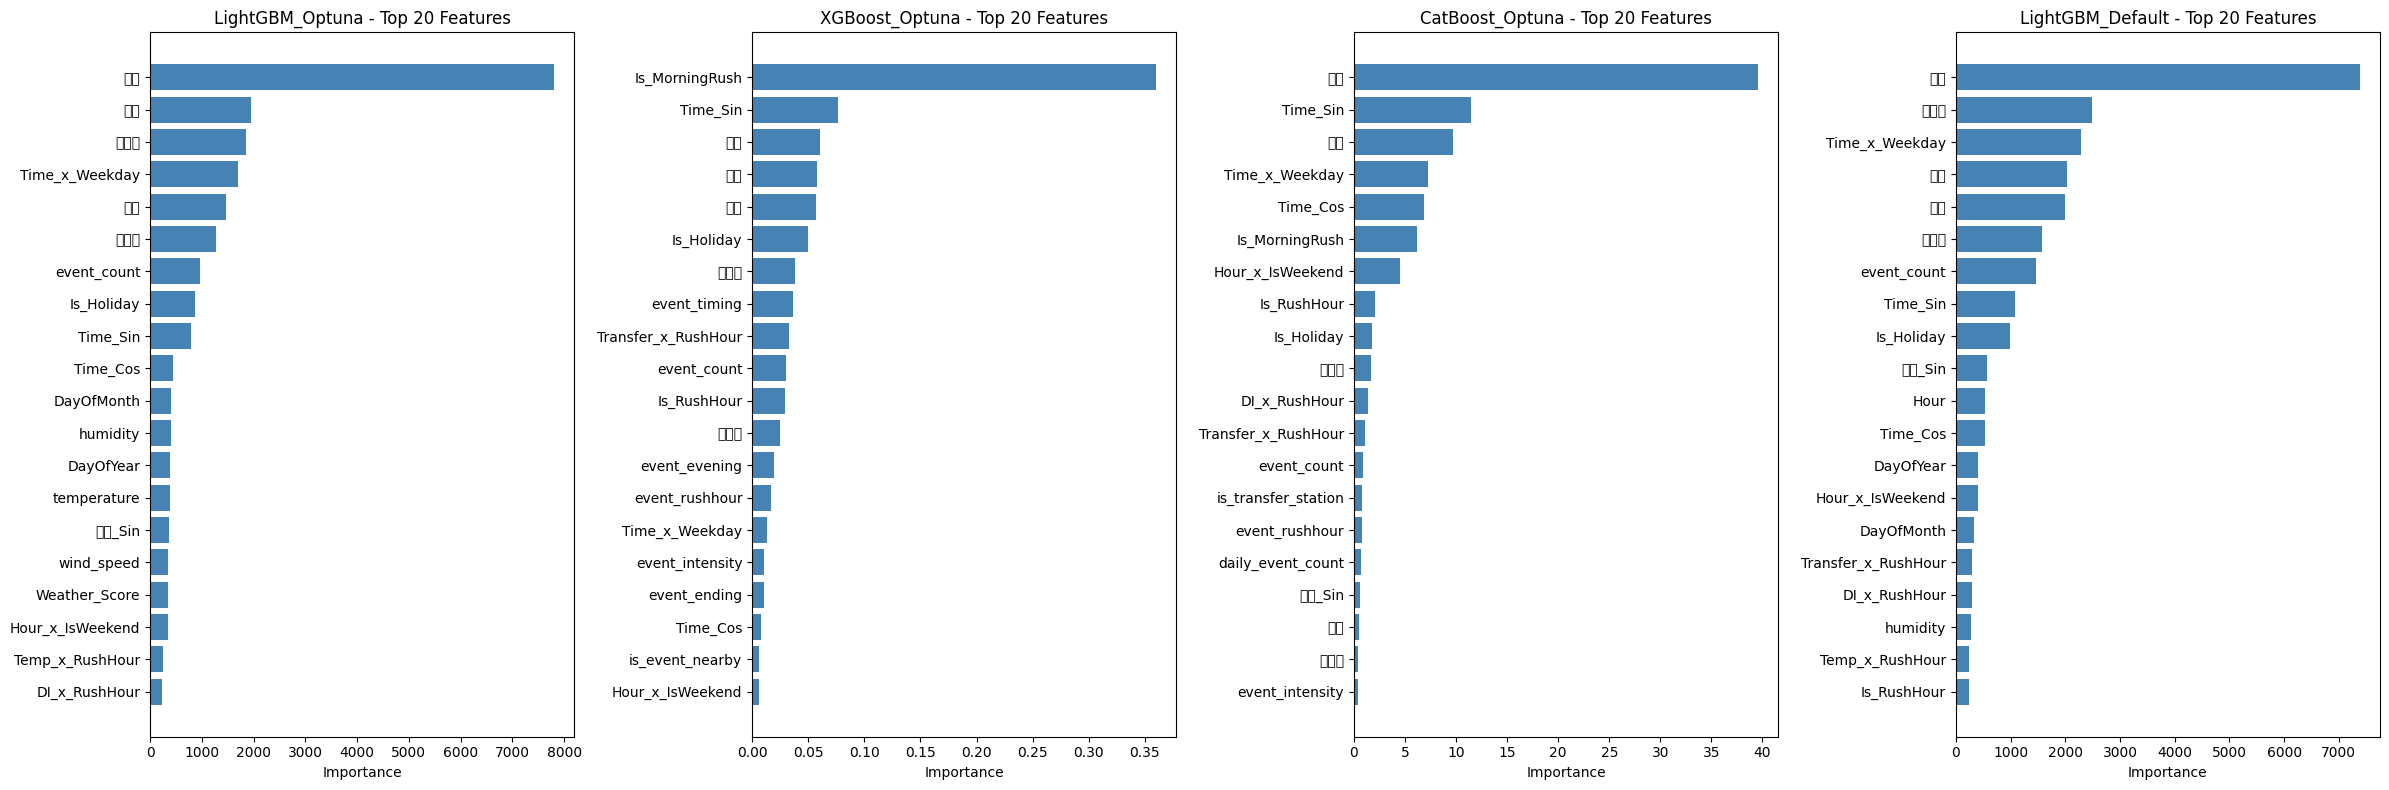


✅ feature_importance.png 저장됨


In [19]:
# =============================================================================
# 13. Feature Importance 시각화
# =============================================================================

# Top 20 Feature Importance
fig, axes = plt.subplots(1, len(feature_importances), figsize=(6*len(feature_importances), 8))
if len(feature_importances) == 1:
    axes = [axes]

for ax, (model_name, importance) in zip(axes, feature_importances.items()):
    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    features = [x[0] for x in sorted_imp]
    values = [x[1] for x in sorted_imp]
    
    ax.barh(range(len(features)), values, color='steelblue')
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name} - Top 20 Features')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ feature_importance.png 저장됨")